In [1]:
import os
from pathlib import Path
import sys
curdir = Path(os.getcwd())
sys.path.append(str(curdir.parent.absolute()))
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from src.utils.data import read_fasta
from src.data.datasets import ProteinDataset
import numpy as np
from src.utils.data import read_pickle
from sklearn.metrics import precision_recall_curve

In [2]:
embeddings = read_pickle('../data/proteinfer_results/proteinfer_embeddings.pkl')

In [3]:
len(embeddings)

522607

In [4]:
test_preds = np.load('../data/proteinfer_results/probas.npy')
test_labels = np.load('../data/proteinfer_results/labels.npy')
test_labels_flat = test_labels.flatten()
test_preds_flat = test_preds.flatten()

In [90]:
test_labels_flat.sum(),test_preds_flat.sum()

(2480830, 2470014.5)

In [48]:
original_test_preds = pd.read_parquet('../proteinfer/export/predictions_df.parquet')
original_test_labels = pd.read_parquet('../proteinfer/export/test_ground_truth.parquet')


In [14]:

def merge_predictions_and_ground_truth(predictions_df, ground_truth_df):
    """Perform an outer join of predictions and ground truth, then set all empty values to False."""
    combined = predictions_df.merge(ground_truth_df,
                                    how="outer",
                                    suffixes=("_pred", "_gt"),
                                    left_on=["label", "up_id"],
                                    right_on=["label", "up_id"])
    combined = combined.fillna(False)
    return combined

In [77]:
l=set(original_test_preds['up_id']) - set(original_test_labels['up_id'])
combined = merge_predictions_and_ground_truth(original_test_preds,original_test_labels)
combined['gt']= combined['gt']*1
combined['value']=combined['value']*1
combined=combined[~combined['up_id'].isin(l)]

In [78]:
combined.groupby('up_id').count()

,label,value,gt
up_id,,,
A0A023PXK2,18,18,18
A0A023PXK7,52,52,52
A0A023PYE4,4,4,4
A0A023PYG1,19,19,19
A0A023PZ99,34,34,34
...,...,...,...
W7MMJ0,19,19,19
W7MX26,45,45,45
X5CWH9,12,12,12


In [85]:
combined['value'].sum(),combined['gt'].sum()

(2361830.8684690297, 2480830)

In [81]:
def filter_pr_curve(precisions, recalls, thresholds, resolution=1e-4):
    """Filters out imperceptible shifts in a PR curve."""
    last_precision = None
    last_recall = None
    new_precisions = []
    new_recalls = []
    new_thresholds = []
    for i in range(len(precisions)):
        if last_precision is None or abs(recalls[i] -
                                         last_recall) >= resolution:
            new_precisions.append(precisions[i])
            last_precision = precisions[i]
            new_recalls.append(recalls[i])
            last_recall = recalls[i]
            new_thresholds.append(thresholds[i])
    return np.array(new_precisions), np.array(new_recalls), np.array(
        new_thresholds)

def _make_tidy_df_from_seq_names_and_prediction_array(
        sequence_names, predictions_array, vocab,
        min_decision_threshold=1e-20):
    """Given a list of sequences and a matrix of prediction values, yield a tidy dataframe of predictions."""
    up_ids = []
    labels = []
    values = []

    for i in range(len(sequence_names)):
        up_id = sequence_names[i]
        preds = predictions_array[i, :]

        for vocab_index in np.argwhere(preds > min_decision_threshold):
            vocab_index = vocab_index[0]
            up_ids.append(up_id)
            labels.append(vocab[vocab_index])
            values.append(preds[vocab_index])
    return pd.DataFrame({"up_id": up_ids, "label": labels, "value": values})


precisions, recalls, thresholds = precision_recall_curve(combined['gt']*1,combined['value']*1)
precisions = precisions[:-1]
recalls = recalls[:-1]
precisions, recalls, thresholds = filter_pr_curve(precisions, recalls, thresholds)


In [82]:
out=pd.DataFrame({
                'precision':
                precisions,
                'recall':
                recalls,
                'threshold':
                thresholds,
                'f1':
                2 * precisions * recalls / (precisions + recalls)})

In [91]:
out.sort_values(by='f1',ascending=False)

,precision,recall,threshold,f1
633,0.921565,0.854018,0.710102,0.886507
631,0.921328,0.854219,0.705771,0.886505
632,0.921444,0.854119,0.707867,0.886505
634,0.921664,0.853916,0.712180,0.886497
635,0.921780,0.853815,0.713999,0.886497
...,...,...,...,...
2,0.720175,0.917845,0.001014,0.807083
1,0.719415,0.917949,0.001000,0.806645
1916,0.989289,0.677492,1.000000,0.804228
1917,0.989410,0.675964,1.000000,0.803189


In [5]:
mask = test_preds_flat>0
test_labels_flat = test_labels_flat[mask]
test_preds_flat = test_preds_flat[mask]

In [6]:

precisions, recalls, thresholds = precision_recall_curve(test_labels_flat,test_preds_flat)
precisions = precisions[:-1]
recalls = recalls[:-1]
#precisions, recalls, thresholds = filter_pr_curve(precisions, recalls, thresholds)
out=pd.DataFrame({
                'precision':
                precisions,
                'recall':
                recalls,
                'threshold':
                thresholds,
                'f1':
                2 * precisions * recalls / (precisions + recalls)})

In [7]:
out.sort_values(by='f1',ascending=False)

,precision,recall,threshold,f1
25667812,0.914438,0.855783,8.544773e-01,0.884139
25667828,0.914443,0.855778,8.545139e-01,0.884139
25667811,0.914437,0.855783,8.544770e-01,0.884139
25667826,0.914443,0.855778,8.545114e-01,0.884138
25667804,0.914435,0.855785,8.544433e-01,0.884138
...,...,...,...,...
4,0.001531,1.000000,2.938848e-39,0.003057
3,0.001531,1.000000,2.938826e-39,0.003057
2,0.001531,1.000000,2.938802e-39,0.003057
1,0.001531,1.000000,2.938781e-39,0.003057


In [18]:
thresholds.shape

(727483,)

In [20]:
metrics_df = pd.DataFrame({'precision':precision[:-1],'recall':recall[:-1],'f1':f1[:-1],'thresholds':thresholds})

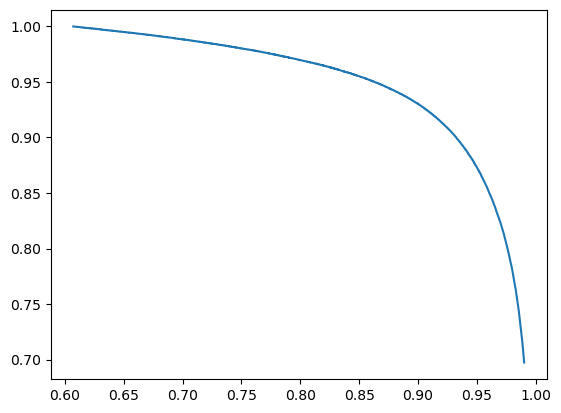

In [22]:
plt.plot(metrics_df['precision'],metrics_df['recall'])

In [21]:
metrics_df.sort_values(by='f1',ascending=False)

,precision,recall,f1,thresholds
629131,0.921198,0.912429,0.916793,0.910039
629129,0.921196,0.912430,0.916792,0.910034
629132,0.921198,0.912428,0.916792,0.910039
629128,0.921196,0.912430,0.916792,0.910034
629130,0.921196,0.912429,0.916792,0.910037
...,...,...,...,...
4,0.607240,1.000000,0.755630,0.001000
3,0.607239,1.000000,0.755630,0.001000
2,0.607238,1.000000,0.755630,0.001000
1,0.607238,1.000000,0.755629,0.001000


In [44]:
train = read_fasta('../data/swissprot/proteinfer_splits/random/train_GO.fasta')
val = read_fasta('../data/swissprot/proteinfer_splits/random/dev_GO.fasta')
test = read_fasta('../data/swissprot/proteinfer_splits/random/test_GO.fasta')

In [66]:
combined[combined['up_id'].isin(l)]['gt'].sum()

0

In [63]:
l

{'P81308',
 'P90212',
 'Q77MT0',
 'O31948',
 'P9WKM6',
 'P9WI30',
 'Q1LT19',
 'Q8CHY7',
 'Q82708',
 'Q29L80',
 'A4ZU89',
 'P75175',
 'Q5E9S8',
 'P0AD23',
 'P45950',
 'Q22004',
 'P53216',
 'P0DKL9',
 'Q99J55',
 'Q9RC95',
 'Q8Y2K9',
 'O27953',
 'Q9SIJ3',
 'P17145',
 'Q6MWV1',
 'Q80VM8',
 'Q54TP6',
 'Q3A1W5',
 'O55724',
 'P34613',
 'Q12484',
 'O95177',
 'Q96EZ4',
 'Q138K0',
 'Q5VXD3',
 'Q9ZGS5',
 'Q37928',
 'Q5X8J5',
 'P28163',
 'P55685',
 'Q32KX8',
 'P36081',
 'O67445',
 'Q05233',
 'Q573E6',
 'P0C9F9',
 'A6NC62',
 'P54330',
 'P13058',
 'P34469',
 'P75066',
 'P0DMW3',
 'P77427',
 'Q1R824',
 'O67900',
 'A3CKK8',
 'P0CT86',
 'Q5MNV8',
 'Q73PH3',
 'Q6ZS30',
 'Q8ST89',
 'B3LLK7',
 'P21036',
 'C6Y4B0',
 'Q47747',
 'Q2NUV6',
 'Q66627',
 'P64810',
 'Q985D2',
 'Q9Z7P6',
 'F4JMH9',
 'Q05298',
 'O31454',
 'P0CT27',
 'Q196V5',
 'O34321',
 'P75684',
 'Q03207',
 'Q6R7J2',
 'P9WIE9',
 'P17616',
 'P20563',
 'P29778',
 'P44086',
 'Q5U3A8',
 'B1XEJ5',
 'P33976',
 'Q8T158',
 'Q7NX05',
 'P55562',
 'Q5UQZ5',

In [62]:
o  = set(original_test_labels['up_id'])
[i[1][0] for i in test if i[1][0] in o]

['Q7Q068',
 'Q3AUB7',
 'Q68X96',
 'B4U3D2',
 'P38344',
 'Q7VL96',
 'Q93ZK9',
 'Q9Z0U4',
 'P9WG88',
 'Q9H1B7',
 'Q4R495',
 'P62416',
 'A0QHY4',
 'Q60753',
 'Q5YRT3',
 'Q31TA1',
 'Q0SXB1',
 'Q3YUH2',
 'B7LC30',
 'B7M8T1',
 'C4ZR48',
 'B1XDS2',
 'A8A7R5',
 'B1IT35',
 'P16384',
 'B6I275',
 'A7ZV40',
 'Q3Z5J1',
 'B6CVD7',
 'Q27115',
 'Q71WQ2',
 'A5G8K2',
 'Q9PHL1',
 'Q0B775',
 'O14014',
 'Q1AWD5',
 'P08148',
 'A9AAQ4',
 'A8GV23',
 'Q1RHC9',
 'A4INW9',
 'Q02809',
 'P45067',
 'B7V4G6',
 'O27495',
 'A6MW12',
 'Q24704',
 'Q5AMR5',
 'Q9HLY3',
 'B3SRX8',
 'A9IRW8',
 'Q9JJ57',
 'B1KMW5',
 'A4Y4I6',
 'A1RME5',
 'Q2NLA8',
 'P06372',
 'A7H2D5',
 'A3Q0V0',
 'Q47033',
 'P0CK11',
 'Q646F1',
 'A7MGF3',
 'P45866',
 'B7HS01',
 'Q4FNH6',
 'B4SQG8',
 'B2FN73',
 'A8IMA7',
 'A9KSH6',
 'B0BQM0',
 'Q08169',
 'Q62976',
 'Q86207',
 'B0D4E7',
 'P28276',
 'P03104',
 'C0RFZ2',
 'Q8PYH6',
 'A2APF3',
 'Q0S4R3',
 'B2KTG1',
 'C5CQ81',
 'Q8DTQ7',
 'B1KZN7',
 'Q74M95',
 'Q23356',
 'Q4QP54',
 'A5UB16',
 'B8LXM1',
 'O42606',

In [ ]:
train = [(k[0],j," ".join(k[1:])) for j,k in train]
test = [(k[0],j," ".join(k[1:])) for j,k in test]
val = [(k[0],j," ".join(k[1:])) for j,k in val]

df = train + val + test

In [4]:
df = pd.DataFrame(df,columns=['id','sequence','labels'])

In [5]:
num_sequences = len(df)
print('number of sequences:',num_sequences)

number of sequences: 522607


In [6]:
labels = Counter()

vocab = set()
amino_freq = Counter()
for idx,row in df.iterrows():
    sequence = row['sequence']
    row_labels = row['labels']
    aa_list = list(sequence)
    if row_labels =='':
        print(row['id'],row['labels'])
    vocab.update(aa_list)
    amino_freq.update(aa_list)
    labels.update(row_labels.split(" "))

In [7]:
print('# GO Terms:',len(labels.keys()))

# GO Terms: 32102


In [8]:
print('GO Terms distribution')
pd.Series(labels.values()).describe()

GO Terms distribution


count     32102.000000
mean        777.250545
std        9114.786603
min           1.000000
25%           4.000000
50%          17.000000
75%          84.000000
max      462356.000000
dtype: float64

In [9]:
print('Sequence length distribution')

df['sequence'].apply(len).describe()

Sequence length distribution


count    522607.000000
mean        368.042215
std         334.721845
min           2.000000
25%         179.000000
50%         303.000000
75%         456.000000
max       35213.000000
Name: sequence, dtype: float64

In [2]:
PD = ProteinDataset(data_path='../data/swissprot/proteinfer_splits/random/train_GO.fasta',
                    sequence_vocabulary_path='../data/vocabularies/amino_acid_vocab.json',
                    label_vocabulary_path='../data/vocabularies/GO_label_vocab.json')

In [3]:
test_seqs_preds = pd.read_csv('../proteinfer/hemoglobin_predictions.tsv',sep='\t')

In [4]:
PD.data = [i for i in PD.data if i[1][0] in ['P69891','Q7AP54']]

In [5]:
from sklearn.metrics import precision_score,recall_score

In [6]:
len(PD),PD.get_max_seq_len()

(2, 569)

In [7]:
from src.models.protein_encoders import ProteInfer
import torch
model = ProteInfer(num_labels=32102,
                      input_channels=20,
                      output_channels=1100,
                      kernel_size=9,
                      activation=torch.nn.ReLU,
                      dilation_base=3,
                      num_resnet_blocks=5,
                      bottleneck_factor=0.5)

from src.utils.proteinfer import transfer_tf_weights_to_torch
transfer_tf_weights_to_torch(model,'../models/proteinfer/GO_model_weights.pkl')

model.to('cuda:0')

Pytorch num variables: 74
Tensorflow num variables: 74


conv1.weight:torch.Size([1100, 20, 9]) <--> inferrer/conv1d/kernel:0:(1100, 20, 9)
conv1.bias:torch.Size([1100]) <--> inferrer/conv1d/bias:0:(1100,)
resnet_blocks.0.bn_activation_1.0.weight:torch.Size([1100]) <--> inferrer/residual_block_0/batch_normalization/gamma:0:(1100,)
resnet_blocks.0.bn_activation_1.0.bias:torch.Size([1100]) <--> inferrer/residual_block_0/batch_normalization/beta:0:(1100,)
resnet_blocks.0.bn_activation_1.0.running_mean:torch.Size([1100]) <--> inferrer/residual_block_0/batch_normalization/moving_mean:0:(1100,)
resnet_blocks.0.bn_activation_1.0.running_var:torch.Size([1100]) <--> inferrer/residual_block_0/batch_normalization/moving_variance:0:(1100,)
resnet_blocks.0.bn_activation_1.0.num_batches_tracked:torch.Size([]) <--> inferrer/residual_block_0/batch_normalization/num_batches_tracked:0:()
resnet_blocks.0.masked_conv1.weight:torch.Size([550, 1100, 9]) <--> inferrer/residual_block_0/conv1d/kernel:0:(550, 1

ProteInfer(
  (conv1): MaskedConv1D(20, 1100, kernel_size=(9,), stride=(1,), padding=same)
  (resnet_blocks): ModuleList(
    (0): Residual(
      (bn_activation_1): Sequential(
        (0): BatchNorm1d(1100, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (1): ReLU()
      )
      (masked_conv1): MaskedConv1D(1100, 550, kernel_size=(9,), stride=(1,), padding=same)
      (bn_activation_2): Sequential(
        (0): BatchNorm1d(550, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (1): ReLU()
      )
      (masked_conv2): MaskedConv1D(550, 1100, kernel_size=(1,), stride=(1,), padding=same)
    )
    (1): Residual(
      (bn_activation_1): Sequential(
        (0): BatchNorm1d(1100, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (1): ReLU()
      )
      (masked_conv1): MaskedConv1D(1100, 550, kernel_size=(9,), stride=(1,), padding=same, dilation=(3,))
      (bn_activation_2): Sequential(
        (0): BatchNorm1d(55

In [9]:
from torch.utils.data import DataLoader
from src.data.collators import collate_variable_sequence_length
PD_loader = DataLoader(dataset=PD,
                          batch_size=2,
                          shuffle=False,
                          num_workers=2,
                          collate_fn=collate_variable_sequence_length)

In [29]:
sd = model.state_dict()
sd['resnet_blocks.0.bn_activation_1.0.running_mean']

tensor([-0.7193, -0.8540, -0.7379,  ..., -0.8559, -0.7143, -0.8150],
       device='cuda:0')

In [10]:
model.eval()
with torch.no_grad():
    for i,s,l in PD_loader:
        logits = model(i.type(torch.FloatTensor).to('cuda:0'),s.to('cuda:0'))
        probas = torch.sigmoid(logits)
        above_th = (probas>0.5)*1


logits torch.Size([2, 32102]) tensor(-25.6217, device='cuda:0') tensor(-1645014.7500, device='cuda:0')


In [2]:
import torch
from src.models.protein_encoders import Residual,ProteInfer
i=torch.ones((8,20,100))
#r=Residual(input_channels=20,kernel_size=9,dilation=9,bottleneck_factor=0.5,activation = torch.nn.ReLU)
prot_enc = ProteInfer(num_labels=32102,input_channels=20,output_channels=1100,kernel_size=9,activation=torch.nn.ReLU,dilation_base=3,num_resnet_blocks=5,bottleneck_factor=0.5)
seqs_lengths = torch.tensor([80,20,5,100,95,80,20,5])
o=prot_enc(i,seqs_lengths)
o.shape

TypeError: conv1d(): argument 'padding' (position 5) must be tuple of ints, not str

In [3]:
from src.utils.proteinfer import transfer_tf_weights_to_torch
transfer_tf_weights_to_torch(prot_enc,'../models/proteinfer/GO_model_weights.pkl')

Pytorch num variables: 74
Tensorflow num variables: 74


conv1.weight:torch.Size([1100, 20, 9]) <--> inferrer/conv1d/kernel:0:(1100, 20, 9)
conv1.bias:torch.Size([1100]) <--> inferrer/conv1d/bias:0:(1100,)
resnet_blocks.0.bn_activation_1.0.weight:torch.Size([1100]) <--> inferrer/residual_block_0/batch_normalization/gamma:0:(1100,)
resnet_blocks.0.bn_activation_1.0.bias:torch.Size([1100]) <--> inferrer/residual_block_0/batch_normalization/beta:0:(1100,)
resnet_blocks.0.bn_activation_1.0.running_mean:torch.Size([1100]) <--> inferrer/residual_block_0/batch_normalization/moving_mean:0:(1100,)
resnet_blocks.0.bn_activation_1.0.running_var:torch.Size([1100]) <--> inferrer/residual_block_0/batch_normalization/moving_variance:0:(1100,)
resnet_blocks.0.bn_activation_1.0.num_batches_tracked:torch.Size([]) <--> inferrer/residual_block_0/batch_normalization/num_batches_tracked:0:()
resnet_blocks.0.masked_conv1.weight:torch.Size([550, 1100, 9]) <--> inferrer/residual_block_0/conv1d/kernel:0:(550, 1

In [4]:
prot_enc

ProteInfer(
  (conv1): MaskedConv1D(20, 1100, kernel_size=(9,), stride=(1,), padding=same)
  (resnet_blocks): ModuleList(
    (0): Residual(
      (bn_activation_1): Sequential(
        (0): BatchNorm1d(1100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
      (masked_conv1): MaskedConv1D(1100, 550, kernel_size=(9,), stride=(1,), padding=same)
      (bn_activation_2): Sequential(
        (0): BatchNorm1d(550, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
      (masked_conv2): MaskedConv1D(550, 1100, kernel_size=(1,), stride=(1,), padding=same)
    )
    (1): Residual(
      (bn_activation_1): Sequential(
        (0): BatchNorm1d(1100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
      (masked_conv1): MaskedConv1D(1100, 550, kernel_size=(9,), stride=(1,), padding=same, dilation=(3,))
      (bn_activation_2): Sequential(
        (0): BatchNorm1d(550, 